# flax_quickstart.ipynb

A copy-paste of [this](https://flax.readthedocs.io/en/latest/quick_start.html), adapted to use PyTorch to handle the training data, based on https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data
import numpy as np
from jax.tree_util import tree_map

In [2]:
data_dir = "/media/z/DATA/datasets/"
batch_size = 10
num_epochs = 10
learning_rate = 0.01
momentum = 0.9

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

def numpy_collate(batch):
  return tree_map(np.asarray, data.default_collate(batch))

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=True,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

trainset = torchvision.datasets.MNIST(root=data_dir, train=True,
                                        download=True, transform=transform)

trainloader = NumpyLoader(trainset,
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=2)

testset = torchvision.datasets.MNIST(root=data_dir, train=False,
                                       download=True, transform=transform)
testloader = NumpyLoader(testset,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=2)


cuda:0


In [3]:
from flax import linen as nn  # Linen API

class CNN(nn.Module):
  """A simple CNN model."""

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    return x

In [4]:
import jax
import jax.numpy as jnp  # JAX NumPy

cnn = CNN()
print(cnn.tabulate(jax.random.key(0), jnp.ones((1, 28, 28, 1)),
                   compute_flops=True, compute_vjp_flops=True))


                                  CNN Summary                                   
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs     ┃ outputs     ┃ flops ┃ vjp_flops ┃ params     ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━┩
│         │ CNN    │ float32[1… │ float32[1,… │ 0     │ 0         │            │
├─────────┼────────┼────────────┼─────────────┼───────┼───────────┼────────────┤
│ Conv_0  │ Conv   │ float32[1… │ float32[1,… │ 0     │ 0         │ bias:      │
│         │        │            │             │       │           │ float32[3… │
│         │        │            │             │       │           │ kernel:    │
│         │        │            │             │       │           │ float32[3… │
│         │        │            │             │       │           │            │
│         │        │            │             │       │           │ 320 (1.3   │
│         │        │       

In [5]:
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers

In [6]:
@struct.dataclass
class Metrics(metrics.Collection):
  accuracy: metrics.Accuracy
  loss: metrics.Average.from_output('loss')

In [7]:
class TrainState(train_state.TrainState):
  metrics: Metrics

def create_train_state(module, rng, learning_rate, momentum):
  """Creates an initial `TrainState`."""
  params = module.init(rng, jnp.ones([1, 28, 28, 1]))['params'] # initialize parameters by passing a template image
  tx = optax.sgd(learning_rate, momentum)
  return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty())

In [8]:
@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

In [9]:
@jax.jit
def compute_metrics(*, state, batch):
  logits = state.apply_fn({'params': state.params}, batch['image'])
  loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
  metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=batch['label'], loss=loss)
  metrics = state.metrics.merge(metric_updates)
  state = state.replace(metrics=metrics)
  return state


In [10]:
init_rng = jax.random.key(0)
state = create_train_state(cnn, init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.


In [11]:
num_steps_per_epoch = len(trainloader) // num_epochs
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}


In [14]:
for step, batch_tuple in enumerate(trainloader):
  # Conv uses a NHWC convenetion for its input, but our trainloader outputs NCHW
  batch = {'image': batch_tuple[0].transpose([0, 2, 3, 1]), 'label': batch_tuple[1]}
  # Run optimization steps over training batches and compute batch metrics
  state = train_step(state, batch) # get updated train state (which contains the updated parameters)
  state = compute_metrics(state=state, batch=batch) # aggregate batch metrics

  if (step+1) % num_steps_per_epoch == 0: # one training epoch has passed
    for metric,value in state.metrics.compute().items(): # compute metrics
      metrics_history[f'train_{metric}'].append(value) # record metrics
    state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

    # Compute metrics on the test set after each training epoch
    test_state = state
    for test_batch_tuple in trainloader:
      test_batch = {'image': test_batch_tuple[0].transpose([0, 2, 3, 1]),
                    'label': test_batch_tuple[1]}
      test_state = compute_metrics(state=test_state, batch=test_batch)

    for metric,value in test_state.metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)

    print(f"train epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['train_loss'][-1]}, "
          f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
    print(f"test epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")


train epoch: 1, loss: 0.03274725005030632, accuracy: 99.08333587646484
test epoch: 1, loss: 0.03363867476582527, accuracy: 98.99500274658203
train epoch: 2, loss: 0.03862741217017174, accuracy: 98.86666870117188
test epoch: 2, loss: 0.03624125197529793, accuracy: 98.82666778564453
train epoch: 3, loss: 0.02972359210252762, accuracy: 99.04999542236328
test epoch: 3, loss: 0.029490437358617783, accuracy: 99.07833099365234
train epoch: 4, loss: 0.0217811930924654, accuracy: 99.46666717529297
test epoch: 4, loss: 0.03273802995681763, accuracy: 98.95166778564453
train epoch: 5, loss: 0.02318991906940937, accuracy: 99.44999694824219
test epoch: 5, loss: 0.03058357909321785, accuracy: 99.03333282470703
train epoch: 6, loss: 0.025831110775470734, accuracy: 99.14999389648438
test epoch: 6, loss: 0.032610852271318436, accuracy: 98.98999786376953
train epoch: 7, loss: 0.029698818922042847, accuracy: 99.08333587646484
test epoch: 7, loss: 0.0332624725997448, accuracy: 99.03166961669922
train epoch

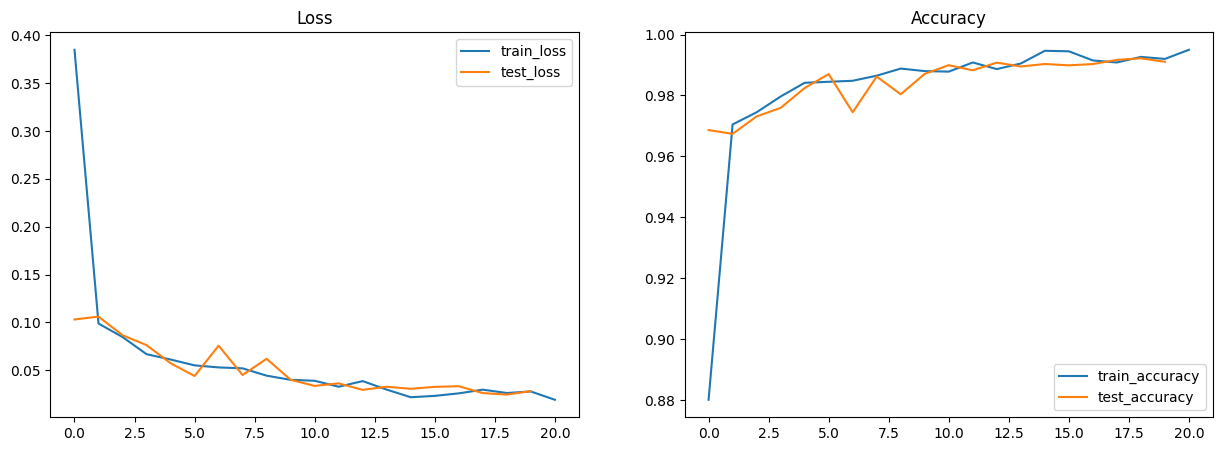

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

---
## Sandbox

In [14]:
import jax
from typing import Any, Callable, Sequence
from jax import random, numpy as jnp
import flax
from flax import linen as nn

In [15]:
# We create one dense layer instance (taking 'features' parameter as input)
model = nn.Dense(features=5)
key1, key2 = random.split(random.key(0))
x = random.normal(key1, (10,)) # Dummy input data
params = model.init(key2, x) # Initialization call
jax.tree_util.tree_map(lambda x: x.shape, params)

{'params': {'bias': (5,), 'kernel': (10, 5)}}

In [16]:
model.apply(params, x)

Array([-1.3721199 ,  0.611315  ,  0.64428365,  2.2192967 , -1.1271119 ],      dtype=float32)

In [17]:
# Set problem dimensions.
n_samples = 20
x_dim = 10
y_dim = 5

# Generate random ground truth W and b.
key = random.key(0)
k1, k2 = random.split(key)
W = random.normal(k1, (x_dim, y_dim))
b = random.normal(k2, (y_dim,))
# Store the parameters in a FrozenDict pytree.
true_params = flax.core.freeze({'params': {'bias': b, 'kernel': W}})

# Generate samples with additional noise.
key_sample, key_noise = random.split(k1)
x_samples = random.normal(key_sample, (n_samples, x_dim))
y_samples = jnp.dot(x_samples, W) + b + 0.1 * random.normal(key_noise,(n_samples, y_dim))
print('x shape:', x_samples.shape, '; y shape:', y_samples.shape)

x shape: (20, 10) ; y shape: (20, 5)


In [18]:
# Same as JAX version but using model.apply().
@jax.jit
def mse(params, x_batched, y_batched):
  # Define the squared loss for a single pair (x,y)
  def squared_error(x, y):
    pred = model.apply(params, x)
    return jnp.inner(y-pred, y-pred) / 2.0
  # Vectorize the previous to compute the average of the loss on all samples.
  return jnp.mean(jax.vmap(squared_error)(x_batched,y_batched), axis=0)

In [19]:
import optax
tx = optax.adam(learning_rate=learning_rate)
opt_state = tx.init(params)
loss_grad_fn = jax.value_and_grad(mse)


In [20]:
for i in range(101):
  loss_val, grads = loss_grad_fn(params, x_samples, y_samples)
  updates, opt_state = tx.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  if i % 10 == 0:
    print('Loss step {}: '.format(i), loss_val)


Loss step 0:  35.343876
Loss step 10:  29.751673
Loss step 20:  24.931484
Loss step 30:  20.849905
Loss step 40:  17.428656
Loss step 50:  14.582544
Loss step 60:  12.222906
Loss step 70:  10.263725
Loss step 80:  8.63257
Loss step 90:  7.271705
Loss step 100:  6.134899
